In [1]:
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from nltk import sent_tokenize
from tokenizers import Tokenizer
import torch

In [4]:
df = pd.read_csv(
    'data/jd.csv', 
#     nrows=1000
)

In [5]:
df

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,TEACHER OF SCIENCE,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244764,72705212,TEACHER OF BUSINESS STUDIES AND ICT,Position: Qualified Teacher or NQT Subject/Spe...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244765,72705213,ENGLISH TEACHER,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244766,72705216,SUPPLY TEACHERS,Position: Qualified Teacher Subject/Specialism...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk


In [6]:
tokenizer = Tokenizer.from_file("data/jd_tokenizer_wordpiece.json")
tokenizer.enable_padding()
tokenizer.enable_truncation(512)

In [7]:
tokenizer.encode_batch(['small sent', 'a larger sent'])

[Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [8]:
from src.utils import DataCollatorForLanguageModeling, LineByLineDataGenerator

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
dc = DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.2)
lblg = LineByLineDataGenerator(tokenizer, dc)

In [10]:
import torch
import math
from torch import nn, optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
from src.layers import SelfAttentionLayer, EncoderBlock

In [12]:
class TransformerRnn_MLM(nn.Module):
    def __init__(self,tokenizer=None, emb_dimension=512, n_head=8, dropout=0.1, n_layers=6):
        super().__init__()
        self.tokenizer = tokenizer
        self.token_encoder = nn.Embedding(tokenizer.get_vocab_size(), emb_dimension)
        self.position_encoder = nn.LSTM(emb_dimension, emb_dimension, batch_first=True)
        
        
        self.encoders = nn.ModuleList([EncoderBlock(emb_dimension, n_head, dropout) for _ in range(n_layers)])
        self.lm_head = nn.Linear(emb_dimension, tokenizer.get_vocab_size())
        
    def forward(self, x, mask=None):
        B, T = x.shape
        x_tok = self.token_encoder(x)
        
        x_emb, _ = self.position_encoder(x_tok)
        
        for block in self.encoders:
            x_emb = block(x_emb, mask)
            
        out = self.lm_head(x_emb)
        return out

In [13]:
transformer_model = TransformerRnn_MLM(tokenizer)
transformer_model.to(device)

TransformerRnn_MLM(
  (token_encoder): Embedding(36000, 512)
  (position_encoder): LSTM(512, 512, batch_first=True)
  (encoders): ModuleList(
    (0): EncoderBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (self_attention): SelfAttentionLayer(
        (qw): Linear(in_features=512, out_features=512, bias=True)
        (kw): Linear(in_features=512, out_features=512, bias=True)
        (vw): Linear(in_features=512, out_features=512, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): EncoderBlock(
      (ln1): La

In [14]:
optimizer = optim.AdamW(transformer_model.parameters())

In [15]:
running_loss = 0.0
losses = []

In [16]:
tokenizer.encode("thiss").ids

[220, 118]

In [17]:
tokenizer.decode([220, 118])

'this ##s'

In [ ]:
accumulation_steps = 8
transformer_model.train()
for index, batch in enumerate(lblg.generate(df.FullDescription.sample(frac=1.0), batch_size=8, max_length=128)):
    if index > 50000:
        break

    inp = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    output = transformer_model(inp)
    output_shape = output.shape
    loss_all = F.cross_entropy(output.view(-1, output_shape[-1]), labels.view(-1), reduction='none')
    loss = loss_all[loss_all > 0].mean()
    lit = loss.item()
    losses.append(lit)
    running_loss = 0.9 * running_loss + 0.1 * lit
    if index % 25 == 0:
        print(f'Running loss at {index} is {running_loss}')
    
    loss = loss / accumulation_steps
    loss.backward()
    if (index+1) % accumulation_steps == 0:  
        optimizer.step()
        optimizer.zero_grad()


Running loss at 0 is 1.0619625091552736
Running loss at 25 is 14.966107193772396
Running loss at 50 is 13.288137882227167
Running loss at 75 is 10.925760078568782
Running loss at 100 is 8.682759937149376
Running loss at 125 is 7.575017956228935
Running loss at 150 is 7.237727565051257
Running loss at 175 is 7.015189010476763
Running loss at 200 is 6.898986802592382
Running loss at 225 is 6.749683723556738
Running loss at 250 is 6.813427401607177
Running loss at 275 is 6.722978825673257
Running loss at 300 is 6.772609074445519
Running loss at 325 is 6.746997588480182
Running loss at 350 is 6.6096184271641905
Running loss at 375 is 6.5720613370541425
Running loss at 400 is 6.630730843624689
Running loss at 425 is 6.678305857348106
Running loss at 450 is 6.6015687558983505
Running loss at 475 is 6.606638294943304
Running loss at 500 is 6.457502405577634
Running loss at 525 is 6.541095737229037
Running loss at 550 is 6.464594528249783
Running loss at 575 is 6.3027569275530055
Running loss 

KeyboardInterrupt: 

In [110]:
(loss_all > 0).sum()

tensor(220, device='cuda:0')

In [19]:
loss_all[loss_all>0].sort()

torch.return_types.sort(
values=tensor([1.1921e-07, 6.1989e-06, 1.2398e-05, 1.9193e-05, 2.0861e-05, 2.2053e-05,
        2.3126e-05, 5.0901e-05, 5.1497e-05, 5.4596e-05, 2.0323e-04, 4.0428e-04,
        4.1047e-04, 4.1512e-04, 5.9587e-04, 6.0254e-04, 7.1381e-04, 8.3662e-04,
        2.0119e-03, 3.0483e-03, 3.2293e-03, 6.1741e-03, 8.9698e-03, 1.1048e-02,
        1.2968e-02, 1.5509e-02, 1.8543e-02, 2.0435e-02, 2.6774e-02, 4.8169e-02,
        5.8932e-02, 6.2731e-02, 6.4784e-02, 6.9545e-02, 7.5172e-02, 8.9313e-02,
        1.0246e-01, 1.0327e-01, 1.1305e-01, 1.2961e-01, 1.3194e-01, 1.4465e-01,
        1.5520e-01, 1.9256e-01, 2.0288e-01, 2.1338e-01, 2.3072e-01, 3.4234e-01,
        3.4329e-01, 3.8262e-01, 4.1821e-01, 4.2969e-01, 4.3794e-01, 4.5663e-01,
        4.9053e-01, 5.0722e-01, 5.5622e-01, 5.6588e-01, 5.8483e-01, 5.9207e-01,
        6.2594e-01, 6.3632e-01, 6.5810e-01, 6.9409e-01, 7.5152e-01, 7.9761e-01,
        8.0282e-01, 8.3105e-01, 9.2402e-01, 9.5093e-01, 1.2428e+00, 1.2509e+00,
        

In [20]:
def save_model(model, PATH):
    torch.save(model.state_dict(), PATH)
    
def load_model(PATH):
    model = RNN_MLM(tokenizer)
    model.load_state_dict(torch.load(PATH, map_location=device))
    model.eval()
    return model

In [21]:
save_model(transformer_model, 'models/transformer_rnn_6_512_bi_wordpiece.pt')
# rnn_mlm_model = load_model('models/rnn_4_bi_wordpiece.pt')

In [22]:
loss

tensor(0.4835, device='cuda:0', grad_fn=<DivBackward0>)

In [29]:
%matplotlib inline

In [26]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly import express as px
import seaborn as sns

<AxesSubplot:>

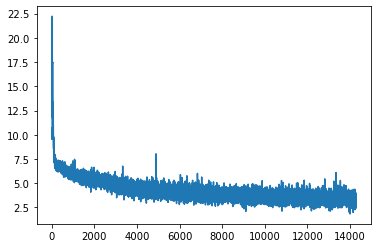

In [23]:
ls = pd.Series(losses)
ls.plot()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning:

All-NaN slice encountered



<AxesSubplot:>

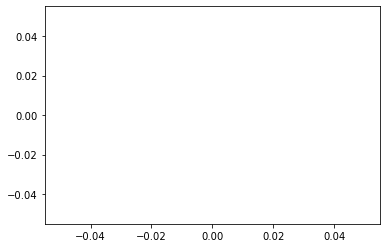

In [30]:
sns.lineplot(ls)

In [117]:
transformer_model.eval()

Transformer_MLM(
  (token_encoder): Embedding(36000, 512)
  (encoders): ModuleList(
    (0): EncoderBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (self_attention): SelfAttentionLayer(
        (qw): Linear(in_features=512, out_features=512, bias=True)
        (kw): Linear(in_features=512, out_features=512, bias=True)
        (vw): Linear(in_features=512, out_features=512, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): EncoderBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      

In [118]:
df[df.Title.notnull() & df.Title.str.contains('Software Developer')].iloc[0]['FullDescription']

'C Developer Belfast Salary up to ****k pa Our client, a leading edge Software Development Centre in Belfast requires C Developers to deliver key software products directly for their clients and for their business teams using the latest Microsoft technologies (.NET C, ASP.NET and SQL Server). Key Accountabilities • Design and develop cuttingedge software solutions, developed in C .Net with SQL as the back end data store. • Ensure all deliverables for projects are completed on time, to budget and within quality standards. • Assist the Project Manager in production of estimates for development activity. • Work with the Business and Data Analysts to drive the requirements forward. • Provide support and consultancy across all test phases of the project. • Participation in planning of software releases, their execution and postrelease activities. • Assist with maintenance and production support. • Support colleagues through advice and technical assistance. Key Technical Skills • A degree in

In [119]:
para = """Designation: Python Distributed [MASK] Engineer
Educational Qualifications: B.Tech/M.Tech/MS/MCA
Experience: 3-9 Years
What you will do
Apply your [MASK] set to fetch data from [MASK] online web sources, cleanse it and [MASK] APIs on top of it.
Work with [MASK] databases (MongoDB) to store raw/document-based data.
Develop a deep [MASK] of our vast data sources on the web and know exactly how, when, and which data to scrape, parse and store.
Develop [MASK] for automating and maintaining a [MASK] flow of data from multiple sources.
Work independently with little supervision to research and test [MASK] solutions.
What you will need
Strong coding [MASK] in Python and [MASK] Web Framework.
Information retrieval – Web [MASK].
Experience with NoSQL data storage like [MASK].
Good knowledge of Asynchronous task [MASK] like Celery.
Experience working with large scale [MASK] and storage.
Knowledge of [MASK] with Node.js is a plus.
Knowledge of [MASK] with various front end technologies and how various websites are built.
Sound [MASK] of Asynchronous Programming in python like AsyncIO."""
# para = para.replace('\n', ' ')
toks = tokenizer.encode(f'[CLS] {para} [SEP]')
toks = torch.tensor([toks.ids]).to(device)

In [120]:
output = transformer_model(toks)
output = output.argmax(dim=-1)[0].cpu()

In [121]:
tokenizer.decode(output.numpy()).replace(' ##', '')

'samarit requirements : python / software engineer educational qualifications : b . c / m . net / ms / office experience : 3 0 9 years what you will do apply your skill set to interrogate data from all online web sources , cleanse it and other apis on top of it . work with relational databases ( mongodb ) to store management / document data based data . develop a deep understanding of our latest data sources on the web and know exactly how , when , and which data to scrape , parse and store . develop solutions for automating and maintaining a smooth flow of data from multiple sources . work independently with little supervision to research and test of solutions . what you will need strong coding skills in python and a web framework . information retrieval – web applications . experience with nosql data storage like technologies . good knowledge of asynchronous task . likeegy . experience working with large scale , and storage . knowledge of working with node . js is a plus . knowledge 

In [51]:
# df[df.FullDescription.str.contains('data science')]

In [57]:
df.FullDescription[5500]

'Location  Leeds. My client, an established and growing IT company are currently recruiting for a Telemarketing Executive. This is an exciting new business sales opportunity to join a forward thinking organisation that continues to go from strength to strength. The Telemarketing Executive role offers an excellent platform for progression to Senior Account Manager. Role Profile: The Telemarketer function is a key position to feed the growth objectives of the organisation. The intention of this position is to drive new clients to a Workshop and/or contact new clients on a range of specific products and service offerings on a project by project basis. The position is a training ground to further graduate onto junior account manager role after approximately ****2 months. It is expected that you will be capable of using the phone and email to convey value of the workshop or project with a qualified decision maker. Key Responsibilities: Your main targets will include: Ability to make **** ou

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [52]:
import gc
# del rnn_mlm_model
# del optimizer
gc.collect()

38

In [ ]:
batch['input_ids'].shape

In [ ]:
output.view(-1, output.shape[-1]).shape

In [ ]:
labels.shape

In [ ]:
out = rnn_mlm_model(batch['input_ids'])

In [ ]:
running_loss = 0.0